In [4]:
"""captum vis"""

import pickle
import random
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization
data_path = '../result/interpret/cn_novel_5billion_cn_novel_5billion_cn_roberta_debug_0_text_len_512_True_vis_record.pkl'
data = pickle.load(open(data_path, 'rb'))
print("data size: ", len(data))

sample_data = random.sample(data, min(len(data), 20))
_ = visualization.visualize_text(sample_data)

data size:  1930


pos_df_avg_attr:  0.022943498497021948
neg_df_avg_attr:  -0.02774758708342908
(5995, 6)
Token:  ，


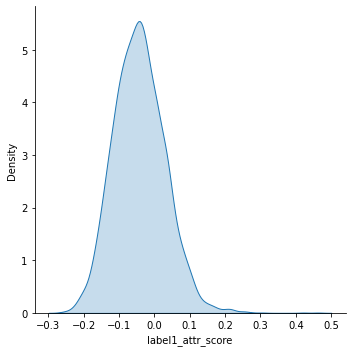

(2804, 6)
Token:  的


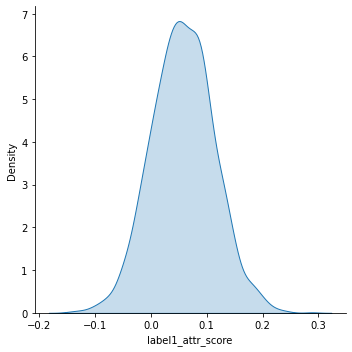

In [16]:
"""attr dis vis"""

import pandas as pd
import numpy as np
import collections
import pdb
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../result/interpret/cn_novel_5billion_cn_novel_5billion_cn_roberta_debug_0_text_len_512_True_token_attr.csv')
tokens = collections.Counter(df['token'].values)
label = 0
keep_N = 2
tokens_counter = sorted(collections.Counter(tokens).items(), key=lambda x:x[1], reverse=True)
pos_df_avg_attr = np.average(df[df['label']==1]['label1_attr_score'].values)
neg_df_avg_attr = np.average(df[df['label']==0]['label1_attr_score'].values)

print('pos_df_avg_attr: ', pos_df_avg_attr)
print('neg_df_avg_attr: ', neg_df_avg_attr)

for token, freq in tokens_counter[:keep_N]:
    token_df = df[(df['token']==token) & (df['label']==label)]
    # attr_score = token_df['label1_attr_score'].values
    print(token_df.shape)
    sns.displot(token_df, x="label1_attr_score", kind="kde", fill=True)
    print('Token: ', token)
    # plt.axvline(pos_df_avg_attr, 0, 5)
    plt.show()
    # pdb.set_trace()

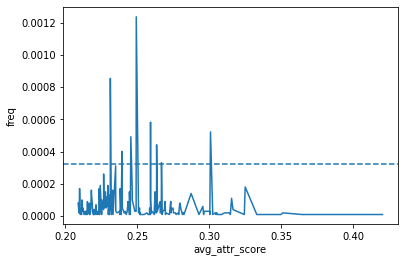

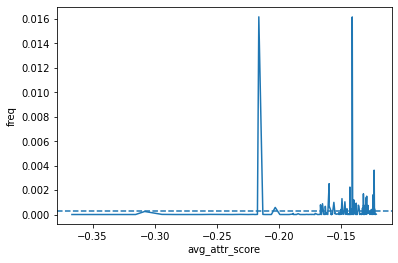

In [72]:
"""
attr dis vis
sort attr from low to high
"""
import pandas as pd
import numpy as np
import collections
import pdb
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../result/interpret/cn_novel_5billion_cn_novel_5billion_cn_roberta_debug_0_text_len_512_True_token_attr.csv')
tokens = collections.Counter(df['token'].values)
pos_df = df[df['label']==1]
neg_df = df[df['label']==0]
keep_N = 200

def plot_df(pos_df, keep_N, is_neg):
    pos_df_counter = collections.Counter(pos_df['token'].values)
    total_count = np.sum(list(pos_df_counter.values()))
    pos_df_counter = {k: v / total_count for k, v in pos_df_counter.items()}
    avg_ratio = np.average(list(pos_df_counter.values()))

    pos_token_attr_score = collections.defaultdict(lambda: [])
    for i, row in pos_df.iterrows():
        token = row['token']
        attr_score = row['label1_attr_score']
        if is_neg:
            if attr_score < 0.0:
                pos_token_attr_score[token].append(attr_score) 
        else:
            if attr_score > 0.0:
                pos_token_attr_score[token].append(attr_score) 

    pos_token_attr_score = {k: np.average(v) for k, v in pos_token_attr_score.items()}

    if is_neg:
        pos_token_attr_score = sorted(pos_token_attr_score.items(), key=lambda x: x[1], reverse=False)[:keep_N]
    else:
        pos_token_attr_score = sorted(pos_token_attr_score.items(), key=lambda x: x[1], reverse=True)[:keep_N]

    pos_plot_df = {'token': [], 'avg_attr_score': [], 'freq': []}
    for token, avg_attr_score in pos_token_attr_score:
        pos_plot_df['token'].append(token)
        pos_plot_df['avg_attr_score'].append(avg_attr_score)
        pos_plot_df['freq'].append(pos_df_counter[token])

    pos_plot_df = pd.DataFrame(pos_plot_df)

    ax = sns.lineplot(data=pos_plot_df, x="avg_attr_score", y="freq")
    ax.axhline(avg_ratio, ls='--')
    plt.show()

plot_df(pos_df, keep_N, False)
plot_df(neg_df, keep_N, True)

freq_attr_dict len:  222


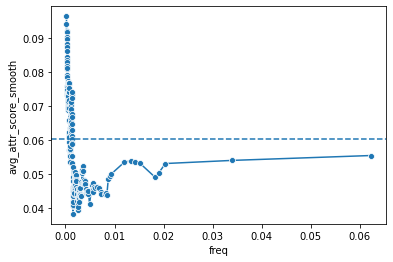

freq_attr_dict len:  248


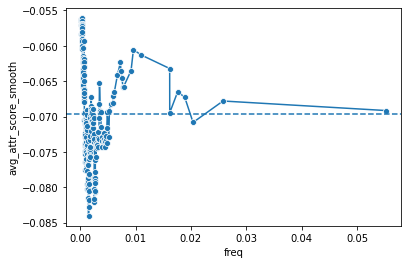

In [69]:
"""
attr dis vis
sort attr from low to high
"""
import pandas as pd
import numpy as np
import collections
import pdb
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../result/interpret/cn_novel_5billion_cn_novel_5billion_cn_roberta_debug_0_text_len_512_True_token_attr.csv')
tokens = collections.Counter(df['token'].values)
pos_df = df[df['label']==1]
neg_df = df[df['label']==0]
keep_N = 500

def plot_df(pos_df, keep_N, is_pos=True, is_top=True):
    pos_df_counter = collections.Counter(pos_df['token'].values)
    # if not is_top:
    #     pos_df_counter = {k: v for k, v in pos_df_counter.items() if v >= 10}
    total_count = np.sum(list(pos_df_counter.values()))
    pos_df_counter = {k: v / total_count for k, v in pos_df_counter.items()}
    # pos_df_counter = sorted(pos_df_counter.items(), key=lambda x:x[1], reverse=is_top)
    
    pos_token_attr_score = collections.defaultdict(lambda: [])
    for i, row in pos_df.iterrows():
        token = row['token']
        attr_score = row['label1_attr_score']
        if is_pos:
            if attr_score > 0.0:
                pos_token_attr_score[token].append(attr_score)
        else:
            if attr_score < 0.0:
                pos_token_attr_score[token].append(attr_score)
    pos_token_attr_score = {k: np.average(v) for k, v in pos_token_attr_score.items()}
    
    freq_attr_dict = collections.defaultdict(lambda: [])
    for token, freq in pos_df_counter.items():
        if token in pos_token_attr_score:
            freq_attr_dict[f'{freq:.6f}'].append(pos_token_attr_score[token])
    freq_attr_dict = {float(k): np.average(v) for k, v in freq_attr_dict.items()}
    print("freq_attr_dict len: ", len(freq_attr_dict))
    freq_attr = sorted(freq_attr_dict.items(), key=lambda x:x[0], reverse=is_top)[:keep_N]
    plot_df = {'freq': [x[0] for x in freq_attr], 'avg_attr_score': [x[1] for x in freq_attr]}
    
    # for token, freq in pos_df_counter:
    #     avg_attr_score = pos_token_attr_score[token]
    #     plot_df['token'].append(token)
    #     plot_df['avg_attr_score'].append(avg_attr_score)
    #     plot_df['freq'].append(freq)
    
    plot_df = pd.DataFrame(plot_df)
    avg_attr_score = plot_df['avg_attr_score'].mean()
    plot_df['avg_attr_score_smooth'] = plot_df['avg_attr_score'].rolling(window=20).mean()
    ax = sns.lineplot(data=plot_df, x="freq", y="avg_attr_score_smooth", marker='o')
    ax.axhline(avg_attr_score, ls='--')
    plt.show()

#plot_df(pos_df, keep_N, is_pos=True)
plot_df(pos_df, keep_N, is_pos=True, is_top=False)
#plot_df(neg_df, keep_N, is_pos=False)
plot_df(neg_df, keep_N, is_pos=False, is_top=False)

pos_df_counter:  3105


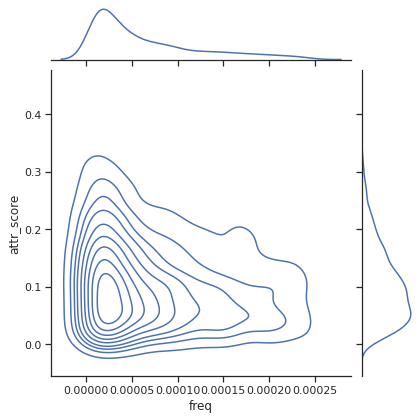

In [88]:
"""
attr dis joint plot
"""
import pandas as pd
import numpy as np
import collections
import pdb
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

df = pd.read_csv('../result/interpret/cn_novel_5billion_cn_novel_5billion_cn_roberta_debug_0_text_len_512_True_token_attr.csv')
tokens = collections.Counter(df['token'].values)
pos_df = df[df['label']==1]
neg_df = df[df['label']==0]
keep_N = 2500

def plot_df(pos_df, keep_N, is_pos=True, is_top=True):
    pos_df_counter = collections.Counter(pos_df['token'].values)
    # if not is_top:
    #     pos_df_counter = {k: v for k, v in pos_df_counter.items() if v >= 10}
    total_count = np.sum(list(pos_df_counter.values()))
    pos_df_counter = {k: v / total_count for k, v in pos_df_counter.items()}
    print("pos_df_counter: ", len(pos_df_counter))
    pos_df_counter = sorted(pos_df_counter.items(), key=lambda x:x[1], reverse=is_top)[:keep_N]
    
    pos_token_attr_score = collections.defaultdict(lambda: [])
    for i, row in pos_df.iterrows():
        token = row['token']
        attr_score = row['label1_attr_score']
        if is_pos:
            if attr_score > 0.0:
                pos_token_attr_score[token].append(attr_score)
        else:
            if attr_score < 0.0:
                pos_token_attr_score[token].append(attr_score)
    pos_token_attr_score = {k: np.average(v) for k, v in pos_token_attr_score.items()}
    
    plot_df = {'freq': [], 'attr_score': []}
    for token, freq in pos_df_counter:
        if token in pos_token_attr_score:
            plot_df['freq'].append(freq)
            plot_df['attr_score'].append(pos_token_attr_score[token])
    plot_df = pd.DataFrame(plot_df)
    ax = sns.jointplot(data=pd.DataFrame(plot_df), x="freq", y="attr_score", kind="kde")
    plt.show()

#plot_df(pos_df, keep_N, is_pos=True)
plot_df(pos_df, keep_N, is_pos=True, is_top=False)
#plot_df(neg_df, keep_N, is_pos=False)
plot_df(neg_df, keep_N, is_pos=False, is_top=False)

